**Before you start, make sure you use the T4 GPU processor (Runtime->Change Runtime-> T4GPU)**

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
ROOT="/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Send the code to the GPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


**Guide for the HW**

This guide has part of the code needed for th homework. An understanding of the same will be of great help for the following exercises.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [4]:
%cd /content/drive/MyDrive/dlss24/

/content/drive/MyDrive/dlss24


In [5]:
%pwd

'/content/drive/MyDrive/dlss24'

# CNN for image classification

In this HW you will do the following steps:


1.   *0.5 Pts*: Write pytorch architecture for ResNet (state of the art CNN architecture with high accuracy)
4.   *1.5 Pts*: Data pre process
5.   *1 Pts*: Fine Tune RestNet
7.   *2 Pts*: Classifying data
8.   *1 Pts*: Test algorithm


**Before you start, make sure you use the T4 GPU processor (Runtime->Change Runtime-> T4GPU)**


## *0.5 Pts*: Pytorch architecture for ResNet

We will use out-of-the-box ResNet from pytorch. To train the model we first definethe "train_model" function. Add the missing code:

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':

                  ### YOUR CODE STARTS HERE ###
                    model.train()    # Set model to training mode
                  ### YOUR CODE ENDS HERE ###

                else:

                  ### YOUR CODE STARTS HERE ###
                    model.eval()  # Set model to evaluate mode
                  ### YOUR CODE ENDS HERE ###

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:

                  ### YOUR CODE STARTS HERE ###

                  #send the inputs and labels to the device (GPU)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                  ### YOUR CODE ENDS HERE ###

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()

                            ### YOUR CODE STARTS HERE ###

                            #update the weights
                            optimizer.step()

                            ### YOUR CODE ENDS HERE ###

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## *1.5 Pts*: Data Preprocess


If you want, you can change the query made here, or add manually pictures to the folders. For the essay, this can be one of the ways to select your data.

In [7]:
import os
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import random

politicians = {
    'SP': ['Christian Levrat', 'Simonetta Sommaruga', 'Alain Berset'],
    'SVP': ['Ueli Maurer', 'Christoph Blocher', 'Guy Parmelin'],
    'FDP': ['Ignazio Cassis', 'Johann Schneider-Ammann', 'Didier Burkhalter'],
    'CVP': ['Doris Leuthard', 'Viola Amherd', 'Gerhard Pfister'],
    'GLP': ['Martin Bäumle', 'Tiana Angelina Moser', 'Jürg Grossen']
}

# Define the ratio of data for training and validation
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

# Create train and val directories
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/val', exist_ok=True)

# Iterate over parties
for party, politicians_list in politicians.items():
    # Shuffle the list of politicians to randomize the data split
    random.shuffle(politicians_list)

    # Calculate the number of images for training and validation
    total_images = len(politicians_list)
    num_train_images = int(total_images * train_ratio)
    num_val_images = total_images - num_train_images

    # Create party directories in train and val directories
    os.makedirs(f'data/train/{party}', exist_ok=True)
    os.makedirs(f'data/val/{party}', exist_ok=True)

    # Iterate over politicians
    for i, politician in enumerate(politicians_list):
        # Determine whether to save the image in train or val directory
        if i < num_train_images:
            data_dir = 'train'
        else:
            data_dir = 'val'

        # Construct the Google search query URL
        query = f"{politician} {party} schweiz"
        url = f"https://www.google.com/search?q={query}&tbm=isch"

        # Send request to Google and parse the response
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        img_tags = soup.find_all("img")

        # Iterate over image tags and save the images
        for j, img_tag in enumerate(img_tags):
            image_url = img_tag["src"]
            if "http" not in image_url:
                continue
            try:
                # Download and save the image
                img_data = requests.get(image_url).content
                img = Image.open(BytesIO(img_data))
                img = img.convert("RGB")
                img.save(f"data/{data_dir}/{party}/{party}_{i}_{j}.jpg")
            except OSError:
                # Handle image processing errors
                print(f"Error processing image {image_url}")


In [ ]:
# 1 PTS: Create a function to eliminate duplicates in train folder:

In [8]:
from PIL import Image
import os
import hashlib

def image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicate_images(folder_path):
    hash_dict = {}
    duplicates = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            filepath = os.path.join(folder_path, filename)
            image_hash_value = image_hash(filepath)
            if image_hash_value in hash_dict:
                duplicates.append(filepath)
            else:
                hash_dict[image_hash_value] = filepath

    return duplicates

def delete_duplicate_images(duplicates):
    for duplicate in duplicates:
        os.remove(duplicate)
        print(f"Deleted: {duplicate}")



In [9]:
train_folder_path = "/content/drive/MyDrive/dlss24/data/train"
for item in os.listdir(train_folder_path):
        item_path = os.path.join(train_folder_path, item)

        duplicates = find_duplicate_images(item_path)
        if duplicates:
            print("Duplicate images found:")
            for duplicate in duplicates:
                print(duplicate)
            delete_duplicate_images(duplicates)
        else:
            print("No duplicate images found.")

No duplicate images found.
No duplicate images found.
No duplicate images found.
Duplicate images found:
/content/drive/MyDrive/dlss24/data/train/SVP/SVP_1_10.jpg
Deleted: /content/drive/MyDrive/dlss24/data/train/SVP/SVP_1_10.jpg
No duplicate images found.


In [10]:
import os
import numpy as np
from torchvision import datasets, transforms

# Define data transforms without normalization
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Define the root directory of your dataset
root_dir = '/content/drive/MyDrive/dlss24/data/train'

# Initialize variables to store sum of pixel values, sum of image sizes, sum of squared pixel values,
# sum of squared image sizes, and number of images
sum_channel_values = np.zeros(3)  # Assuming RGB images, so 3 channels
sum_image_sizes = np.zeros(2)  # Height and width
sum_squared_channel_values = np.zeros(3)
sum_squared_image_sizes = np.zeros(2)
num_images = 0

# Iterate over each class folder
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        # Iterate over each image in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = datasets.folder.default_loader(image_path)
            image_np = np.array(image)
            mean_pixel_values = np.mean(image_np, axis=(0, 1))  # Compute mean pixel values for each channel
            sum_channel_values += mean_pixel_values
            sum_squared_channel_values += np.sum((image_np - mean_pixel_values) ** 2, axis=(0, 1))  # Sum of squared pixel values
            sum_image_sizes += image_np.shape[:2]  # Accumulate height and width
            sum_squared_image_sizes += (image_np.shape[0] ** 2, image_np.shape[1] ** 2)  # Sum of squared image sizes
            num_images += 1  # Accumulate number of images

# Compute mean values for each channel and mean size
mean_values = sum_channel_values / num_images
mean_size = sum_image_sizes / num_images

# Compute standard deviation values for each channel and size
std_values = np.sqrt(sum_squared_channel_values / num_images - (sum_channel_values / num_images) ** 2)
std_size = np.sqrt(sum_squared_image_sizes / num_images - (sum_image_sizes / num_images) ** 2)

print("Mean values for each channel:", mean_values)
print("Mean size of images (height, width):", mean_size)
print("Standard deviation for each channel:", std_values)
print("Standard deviation of image size (height, width):", std_size)


Mean values for each channel: [137.76764103 125.10335009 120.40617528]
Mean size of images (height, width): [114.8241206  148.52261307]
Standard deviation for each channel: [8965.20169001 8637.28226665 8662.12068618]
Standard deviation of image size (height, width): [20.64449556 22.73549549]


In [11]:
# 0.5 PTS: Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        ### YOUR CODE STARTS HERE ###

        # ... transformation for data augmentention 1
        # ... transformation for data augmentention 2
        # ... send to tensor
        # ... normalize

        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # OR [137.76764103 ,125.10335009 ,120.40617528], [8965.20169001 ,8637.28226665, 8662.12068618] (those are the mean and se for the image net, these are for the images from the google query)

        ### YOUR CODE ENDS HERE ###
    ]),
    'val': transforms.Compose([
        ### YOUR CODE STARTS HERE ###

        # ... different size than training
        # ... repeat needed transformation to be consistent with training

        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # OR [137.76764103 ,125.10335009 ,120.40617528], [8965.20169001 ,8637.28226665, 8662.12068618] (those are the mean and se for the image net, these are for the images from the google query)


        ### YOUR CODE ENDS HERE ###
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Confirm your transformations:

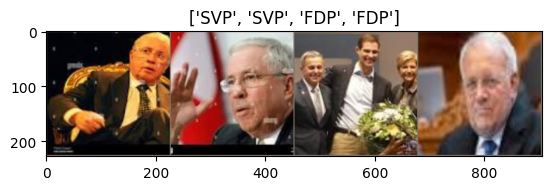

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## *1 Pts*: Fine Tune RestNet

Train the model from scratch (1) and fine tuned (2)

In [13]:
# From scratch training (1)

### YOUR CODE STARTS HERE ###

model_scr = models.resnet18() #initialize resnet18 model

# define how many classes your problem has
num_classes= 5


### YOUR CODE ENDS HERE ###

# number of features the ResNet architecture deals with
num_ftrs = model_scr.fc.in_features
model_scr.fc = nn.Linear(num_ftrs,num_classes)


In [14]:

### YOUR CODE STARTS HERE ###
# specify the right loss function for classification
model_scr = model_scr.to(device)

# specify the right loss function for classification
criterion = nn.CrossEntropyLoss()
### YOUR CODE ENDS HERE ###



In [15]:

# Observe that all parameters are being optimized
optimizer_scr = optim.SGD(model_scr.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scr, step_size=7, gamma=0.1)


In [16]:
### YOUR CODE STARTS HERE ###
#use the first function defined: train_model
model_scr = train_model(model_scr, criterion, optimizer_scr, exp_lr_scheduler,
                       num_epochs=25)

### YOUR CODE ENDS HERE ###

Epoch 0/24
----------
train Loss: 1.8013 Acc: 0.2060
val Loss: 2.0186 Acc: 0.2000

Epoch 1/24
----------
train Loss: 1.7604 Acc: 0.2111
val Loss: 1.9421 Acc: 0.2000

Epoch 2/24
----------
train Loss: 1.7213 Acc: 0.2362
val Loss: 2.3116 Acc: 0.2300

Epoch 3/24
----------
train Loss: 1.8632 Acc: 0.2060
val Loss: 1.8777 Acc: 0.2200

Epoch 4/24
----------
train Loss: 1.8099 Acc: 0.2111
val Loss: 1.9546 Acc: 0.2800

Epoch 5/24
----------
train Loss: 1.6763 Acc: 0.2915
val Loss: 1.7568 Acc: 0.2900

Epoch 6/24
----------
train Loss: 1.7352 Acc: 0.2462
val Loss: 1.8249 Acc: 0.2100

Epoch 7/24
----------
train Loss: 1.5443 Acc: 0.3367
val Loss: 1.7968 Acc: 0.2700

Epoch 8/24
----------
train Loss: 1.4844 Acc: 0.3618
val Loss: 1.8232 Acc: 0.2000

Epoch 9/24
----------
train Loss: 1.4954 Acc: 0.3719
val Loss: 1.8629 Acc: 0.1700

Epoch 10/24
----------
train Loss: 1.5031 Acc: 0.3116
val Loss: 1.8296 Acc: 0.1700

Epoch 11/24
----------
train Loss: 1.5033 Acc: 0.3166
val Loss: 2.0489 Acc: 0.2200

Ep

In [17]:
# Fine Tuning(2)

### YOUR CODE STARTS HERE ###
#Re do the previous code but fine tuning the initial resnet model.
#Finetuning means starting with previously trained weights

model_ft = models.resnet18(weights='IMAGENET1K_V1') #initialize resnet18 model

# define how many classes your problem has
num_classes= 5


### YOUR CODE ENDS HERE ###

# number of features the ResNet architecture deals with
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes)

# specify the right loss function for classification
model_scr = model_ft.to(device)

# specify the right loss function for classification
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_scr = optim.SGD(model_scr.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scr, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_scr, exp_lr_scheduler,
                       num_epochs=25)



### YOUR CODE ENDS HERE ###

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 0/24
----------
train Loss: 1.7999 Acc: 0.1759
val Loss: 1.8091 Acc: 0.1900

Epoch 1/24
----------
train Loss: 1.6613 Acc: 0.2965
val Loss: 1.5636 Acc: 0.3800

Epoch 2/24
----------
train Loss: 1.5130 Acc: 0.3920
val Loss: 1.7097 Acc: 0.3600

Epoch 3/24
----------
train Loss: 1.4136 Acc: 0.4372
val Loss: 2.0363 Acc: 0.3100

Epoch 4/24
----------
train Loss: 1.3843 Acc: 0.4472
val Loss: 2.2388 Acc: 0.2500

Epoch 5/24
----------
train Loss: 1.2461 Acc: 0.5276
val Loss: 2.5751 Acc: 0.2900

Epoch 6/24
----------
train Loss: 1.2789 Acc: 0.5126
val Loss: 2.2319 Acc: 0.2500

Epoch 7/24
----------
train Loss: 0.9406 Acc: 0.6080
val Loss: 1.9387 Acc: 0.2800

Epoch 8/24
----------
train Loss: 0.8875 Acc: 0.6683
val Loss: 1.9640 Acc: 0.2700

Epoch 9/24
----------
train Loss: 0.9423 Acc: 0.6231
val Loss: 2.0146 Acc: 0.2600

Epoch 10/24
----------
train Loss: 0.9001 Acc: 0.6784
val Loss: 2.1516 Acc: 0.2900

Epoch 11/24
----------
train Loss: 0.8667 Acc: 0.6482
val Loss: 2.1076 Acc: 0.2600

Ep

## *2 Pts*: Classifying data

In [ ]:
# 1 PTS:  Print a confusion matrix from the best performance model you built

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming `test_loader` is your DataLoader for the test dataset
def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return all_preds, all_labels

# After training the model
test_preds, test_labels = test_model(model_ft, criterion, dataloaders['val'])

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Loss: 2.6134, Test Acc: 0.2929
Confusion Matrix:
[[ 0  9  5  3  3]
 [ 1 10  0  2  6]
 [ 1  7  6  5  1]
 [ 0 13  1  3  3]
 [ 0  6  3  1 10]]


In [ ]:
import pandas as pd
class_labels = ['CVP', 'FDP', 'GLP', 'SP', 'SVP']
df_conf_matrix = pd.DataFrame(conf_matrix, columns=class_labels, index=class_labels)
df_conf_matrix

,0,1,2,3,4,5
0,0,CVP,FDP,GLP,SP,SVP
1,CVP,0,9,5,3,3
2,FDP,1,10,0,2,6
3,GLP,1,7,6,5,1
4,SP,0,13,1,3,3
5,SVP,0,6,3,1,10


In [ ]:
# 1 PTS:  Define the steps for the best performer (data pre processing steps and model choices)
# interpret and justify the metrics

The **data pre processing** steps in the data_transforms variable follow this rationale:


*   Different sizes for the same image: randomresizedcrop. The value is the average size of images
*   Different mirror perspectives: RandomHorizontalFlip
*   Optimize training times and results: normalize the pizel values with Normalize

these transformations aim to increase the number of samples both in training and validation dataset. For validation a different resize is done to see if the model is robust. The same normalization should be applied in training as in validation.


The **model choices** were based on:


*   Number of classes: the number of parties in the dataset
*   Loss function: cross entropy deals with multi class classification
*   Pre-learned weights: we just follow the default weights that can be uploaded


The **metrics and the model performance** are quite low and dependent on the data available. The fine tuning versionnhas 10% more accuracy than the from the scratch one, although it is still under 70% threshold to be an acceptable model. The confusion matrix is useful to know which call needs to have more sample images and which classes are too similar. SP (0 tru positives) and CVP (3 tru positives) are the ones that need more samples, and there is also the need to distinguish between FDP and CVP and SP and FDP.


## *1 Pts*: Test algorithm

In [ ]:
# Build a function to predict a new image (choose/upload a new one that is not on train or validation folder)

In [19]:
from PIL import Image
import torchvision.transforms as transforms

# Define the transformation to match training preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_labels = ['CVP', 'FDP', 'GLP', 'SP', 'SVP']

# Load the image
image_path = '/content/drive/MyDrive/dlss24/dlss24/Screenshot 2024-05-30 at 15.59.46.jpg'  # replace with the path to your image
image = Image.open(image_path)

# Preprocess the image
image = data_transforms(image).unsqueeze(0)

# Move the image to the same device as the model
image = image.to(device)

# Put the model in evaluation mode
model_ft.eval()

# Run the image through the model
with torch.no_grad():
    outputs = model_ft(image)
    _, preds = torch.max(outputs, 1)

# Get the class label
class_idx = preds.item()

# Print the predicted class label
print(f'Predicted class: {class_labels[class_idx]}') # it's SVP


Predicted class: FDP
